## Freni-Sterrantino et al 2017 - BYM2 connected, disconnected for Scotland Lip Cancer Dataset

Mitzi Morris

In [A note on intrinsic Conditional Autoregressive models for disconnected graphs](https://arxiv.org/abs/1705.04854), Freni-Sterrantino et.al. show how to implement the BYM2 model for use with areal data where the graph structure of the map is not fully connected.  In this notebook, we present that Stan implementation of this proposal.

The BYM2 model provides an intuitive parameterization for a GLM which has both an ICAR component $\phi$ which accounts for the spatial structure of the data, and a ordinaty random effects component $\theta$ for non-spatial heterogeneity.
In addition, the BYM2 model has a single precision (scale) parameter $\sigma$ on the combined components
and a mixing parameter $\rho$ for the amount of spatial/non-spatial variation.
In order for $\sigma$ to legitimately be the standard deviation of the combined components,
it is critical that for each $i$, $\operatorname{Var}(\phi_i) \approx \operatorname{Var}(\theta_i) \approx 1$.
This is done by adding a scaling factor $\tau$ to the model which scales 
the proportion of variance $\rho$.
Riebler et al. recommend scaling the model so the geometric mean of these variances is 1.
Because the scaling factor depends on the dataset, it comes into the model as data.

The Stan case study [Spatial Models in Stan: Intrinsic Auto-Regressive Models for Areal Data](https://mc-stan.org/users/documentation/case-studies/icar_stan.html) for details on the ICAR, BYM, and BYM2 models. 

### Overview of BYM2 model for a fully connected spatial structure

When the areal map is a single, fully connected component, i.e., a graph where any node in the graph can be reached from any other node, the BYM2 model is implemented as follows.

The spatial structure and scaling factor are data inputs to the model:

```
data {
  int<lower = 0> I;  // number of nodes
  int<lower = 0> J;  // number of edges
  int<lower = 1, upper = I> edges[2, J];  // node[1, j] adjacent to node[2, j]
  real tau; // scaling factor
```

The spatial and heterogeneous effects, combined variance, and proportion of spatial variance are model parameters:

```
parameters {
  real<lower=0, upper=1> rho; // proportion of spatial effect that's spatially smoothed
  real<lower = 0> sigma;  // scale of spatial effects
  vector[I] theta;  // standardized heterogeneous spatial effects
  vector[I] phi;  // standardized spatially smoothed spatial effects
```

The combined BYM2 component is computed in the `transformed parameters` block:

```
transformed parameters {
  // spatial effects (combine heterogeneous and spatially smoothed)
  vector[I] gamma = (sqrt(1 - rho) * theta + sqrt(rho / tau) * phi) * sigma;
```

The ICAR component is implemented as log probability density function which computes the ICAR pairwise difference and imposes a soft sum-to-zero constraint:

```
real standard_icar_lpdf(vector phi, int[ , ] adjacency) {
    return 0.5 * dot_self(phi[adjacency[1,]] - phi[adjacency[2]])
	  + normal_lpdf(sum(phi) | 0, 0.001 * rows(phi));
}
```

### Freni-Sterrantino recommendations for a disconnected graph and Stan implementation

Freni-Sterrantino et al show how to adjust the scaling factors when the areal map is not fully connected but has at least one connected multi-node component.  

1. Each connected component of size > 1 is scaled independently
2. Components of size 1 are scaled with a normal with precision K, where K is the number of components.

To extend the BYM2 model to these areal maps, we agument this model with a series of per-component masks into the node and edgelists and use Stan's multi-index operator and vectorized operations for efficient computation.

The spatial structure includes a set of arrays describing component-wise node, edgesets.
The `_cts` arrays record the size of the node and edgelists for each component, the `_idx` arrays provide the indices of the members of each component.

```
 int<lower=0, upper=I> K;  // number of components in spatial graph
  int<lower=0, upper=I> K_node_cts[K];   // per-component nodes
  int<lower=0, upper=J> K_edge_cts[K];   // per-component edges
  int<lower=0, upper=I> K_node_idxs[K, I];  // rows contain per-component node indexes
  int<lower=0, upper=J> K_edge_idxs[K, J];  // rows contain per-component edge indexes

  vector[K] tau; // scaling factor
```

Per recommendataion 1, above, the combined spatial and random effects in the BYM2 model are computed component-wise, each with their own scaling factor.  For singletons, the scaling factor `tau` is 1/K.

```
transformed parameters {
  vector[I] gamma;
  // each component scaled by tau[k]
  for (k in 1:K)
    gamma[K_node_idxs[k, 1:K_node_cts[k]]] = 
            (sqrt(1 - rho) * theta[K_node_idxs[k, 1:K_node_cts[k]]]
             +
             sqrt(rho / tau) * phi[K_node_idxs[k, 1:K_node_cts[k]]])
            * sigma;
```

The ICAR `_lpdf` function puts a sum-to-zero constraint on each component.
Singletons have normal spatial variance.

```
real standard_icar_disconnected_lpdf(vector phi,
				       int[ , ] adjacency,
				       int[ ] node_cts,
				       int[ ] edge_cts,
				       int[ , ] node_idxs,
				       int[ , ] edge_idxs) {
    real total = 0;
    for (n in 1:size(node_cts)) {
      if (node_cts[n] > 1)
        total += -0.5 * dot_self(phi[adjacency[1, edge_idxs[n, 1:edge_cts[n]]]] -
                                 phi[adjacency[2, edge_idxs[n, 1:edge_cts[n]]]])
                  + normal_lpdf(sum(phi[node_idxs[n, 1:node_cts[n]]]) |
                                      0, 0.001 * node_cts[n]);
      else
          total += normal_lpdf(phi[n] | 0, 1);  // iid spatial variance
    }
    return total;
}
```


### Python packages used in this notebook, including CmdStanPy

In [1]:
import json

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

import numpy as np
import pandas as pd

from cmdstanpy import cmdstan_path, CmdStanModel, install_cmdstan
# install_cmdstan()  # as needed - will install latest release (as needed)

### Areal data:  the counties in Scotland, circa 1980

The canonical dataset used to test and compare different parameterizations of ICAR models is a study on the incidence of lip cancer in Scotland in the 1970s and 1980s.  The data, including the names and coordinates for the counties of Scotland are available from R package [SpatialEpi](https://cran.r-project.org/web/packages/SpatialEpi/SpatialEpi.pdf), dataset `scotland`.

3 of these counties are islands:  the Outer Hebrides (western.isles), Shetland, and Orkney.  In the canonical datasets, these islands are conntected to the mainland, so that the adjacency graph consists of a single, fully connected component.  However, different maps are possible:  a map with 4 components, the mainland and the 3 islands; or a map with 3 components:  the mainland, a component consisting of Shetland and Orkney, and a singleton consisting of the Hebrides. The following plots demonstrate the differences:

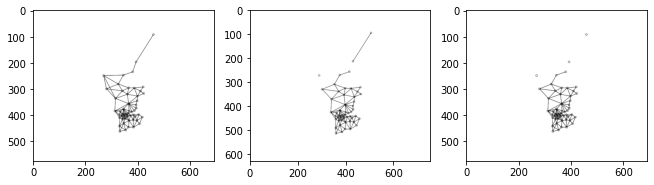

In [2]:
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8
img_A = mpimg.imread('scot_connected.png')
img_B = mpimg.imread('scot_3_comp.png')
img_C = mpimg.imread('scot_islands.png')
# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(img_A);
ax[1].imshow(img_B);
ax[2].imshow(img_C);

The graph nodes which have different amounds of connectivity are:  1: "sky-lochalsh" , 3: "caithnes", 5: "ross-cromarty", 6: "shetland", 8: "orkney", 9: "moray", 11: "western.isles", 12: "sutherland".

### Data prep:  from spatial polygon to 2D array of edges

In the Stan implementation of the ICAR model, the edgelist is a 2D array of size 2 $\times$ J where J is the number of edges in the graph.  Each column entry in this array represents one undirected edge in the graph, where for each edge j, entries [j,1] and [j,2] index the nodes connected by that edge.  Treating these are parallel arrays and using Stan's vectorized operations provides a transparent implementation of the pairwise difference formula used to compute the ICAR component.

The common format for the spatial structure of an areal dataset is as a set of shapefiles.  The areal regions are described by a set of spatial polygons, i.e., a description of the shape of each region in terms of its lat,lon coordinates.  The R package [spdep](https://r-spatial.github.io/spdep/index.html) extracts the adjacency relations as a `nb` object.
We have written a set of helper functions which take the `nb` objects for each graph into the set of data structures needed by the Stan models, these are in file `bym2_helpers.R`.  The helper function `nb_to_edge_array` takes the `nb` object and returns the 2 $\times$ J edge array; the helper function `scaling_factor` uses the edge array to compute the geometric mean of the corresponding adjacency matrix.


The `scotland` dataset contains the shapefiles for the counties in Scotland.  The fully connected graph corresponds to the data as distributed.  By editing the `nb` objects, we have created the alternative maps above.
The three versions of the Scotland spatial structure are in files `scotland_nbs.data.R`, `scotland_3_comp_nbs.data.R`, and `scotland_islands_nbs.data.R`.
The file `munge_scotland.R` munges the data, and it has been saved as JSON data files.

### Regression data:  the Scotland cancer dataset

The cancer study data is:

- `y`: observed outcome - number of cases of lip cancer
- `x`: single predictor - percent of population working in agriculture, forestry, or fisheries.
- `E`: population
    
This dataset is available via several different R packages; often `x` is called `AFF`; sometime it is given as a percentage, i.e., scaled from 1 to 100; sometimes as a proportion, scaled from 0 to 1.  The version of this dataset distributed as a BUGS example scales the percentage by 1/10, as does the INLA model.  In order to compare the Stan results with INLA et al, in this dataset, `x`, the percenatage population, is also scaled by 1/10.

### Fitting the BYM2_islands model to Scotland map as mainland component plus islands

For the Scotland map with 3 island (singleton) components, in file `scotland_islands_nbs.data.R`, we use function index_components and write_json produce the input data file `scotland_islands.data.json`.   This map has the same nodes set as in the `scotland` dataset, but the neighbors object (file `scotland_nbs.data.R`) has been edited to remove all edges between islands and the mainland or each other.

In [3]:
with open('scotland_islands.data.json') as fd:
    islands_data = json.load(fd)

print('num nodes: {}, num edges: {}'.format(islands_data['I'], islands_data['J']))

num nodes: 56, num edges: 126


The `index_components` function creates the per-component node and edge index arrays, and computes the vector of scaling factors `tau`:

In [4]:
print('num components: {}\nscaling factors: {}\nnodes per component: {}\nnode indices: {}'.format(
    islands_data['K'], islands_data['tau'], islands_data['K_node_cts'], islands_data['K_node_idxs']))

num components: 4
scaling factors: [0.4504, 0.25, 0.25, 0.25]
nodes per component: [53, 1, 1, 1]
node indices: [[1, 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 0, 0, 0], [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


We use CmdStanPy to compile and fit the model using 

In [5]:
from cmdstanpy import cmdstan_path, CmdStanModel
bym2_islands_model = CmdStanModel(stan_file='bym2_islands.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/mitzi/github/stan-dev/example-models/knitr/car-iar-poisson/update_2021_02/bym2_islands


In [6]:
print(bym2_islands_model.code())

functions {
  /**
   * Return the log probability density of the specified vector of
   * coefficients under the ICAR model with unit variance, where
   * adjacency is determined by the adjacency array and the spatial
   * structure is a disconnected graph which has at least one
   * connected component.  Each connected component has a
   * soft sum-to-zero constraint.   Singleton nodes have
   * distribution normal(0, 1/sqrt(K))
   *
   * The spatial structure is described by a 2-D adjacency array
   * over the all edges in the areal map and a arrays of the
   * indices of per-component nodes and edges which are used as
   * masks into phi and the adjacency matrix.   Because the Stan
   * language lacks ragged arrays, these are all square matrices,
   * padded out with zeros; additional vectors record the number
   * of nodes and edges in each component.
   *
   * @param phi vector of varying effects
   * @param adjacency parallel arrays of indexes of adjacent elements of phi
   * @pa

We fit the model using the data dictionary `islands_data`, alternatively, one can specify file `scotland_islands.data.json`.  For reproducibility, we specify the seed supplied to the Stan pseudo-random number generator used by the sampler.

In [7]:
bym2_islands_fit = bym2_islands_model.sample(data=islands_data, seed=12345)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


The CmdStanMCMC method `summary` wraps the CmdStan [`stansummary`](https://mc-stan.org/docs/cmdstan-guide/stansummary.html) utility; it returns a pandas DataFrame object, one row per summary output row for the joint log probability density `lp__` and for the values of all variables in the Stan program.

In [8]:
islands_summary = bym2_islands_fit.summary()
islands_summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,750.00,0.2800,9.000,730.00,750.00,760.000,1000.0,70.00,1.00
alpha,-0.29,0.0027,0.130,-0.50,-0.29,-0.078,2200.0,150.00,1.00
beta,0.41,0.0031,0.140,0.18,0.41,0.630,1900.0,130.00,1.00
rho,0.85,0.0068,0.160,0.50,0.90,1.000,570.0,40.00,1.00
sigma,0.70,0.0016,0.056,0.61,0.70,0.800,1300.0,89.00,1.00
...,...,...,...,...,...,...,...,...,...
y_prime[53],2.30,0.0090,0.820,1.20,2.20,3.800,8326.0,578.00,1.00
y_prime[54],2.80,0.0120,0.960,1.50,2.70,4.600,6767.0,469.00,1.00
y_prime[55],3.60,0.0170,1.200,1.80,3.50,5.800,4996.0,347.00,1.00


The R_hat and N_Eff (number of effective samples) in the summary report indicate that the model has fit the data.  To further check the fit, we run the `diagnose` method, which wraps CmdStan's [`diagnose`](https://mc-stan.org/docs/cmdstan-guide/diagnose.html) utility.

In [9]:
bym2_islands_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpqbvykf4y/bym2_islands-202102261942-1-jerlq96w.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpqbvykf4y/bym2_islands-202102261942-2-ln_lz2hh.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpqbvykf4y/bym2_islands-202102261942-3-t0g48k_u.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpqbvykf4y/bym2_islands-202102261942-4-gwm08ytv.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpqbvykf4y/bym2_islands-202102261942-1-jerlq96w.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpqbvykf4y/bym2_islands-202102261942-2-ln_lz2hh.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpqbvykf4y/bym2_islands-202102261942-3-t0g48k_u.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpqbvykf4y/bym2_islands-202102261942-4-gwm08ytv.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

The diagnose command detects _potential_ problems by examining the set of sampler diagnostic variables; these are the initial columns of the Stan CSV output file, which have column labels which end in `__`.  For example, to further check the treedepth, which is an integer output between 1 and sampler configuration argument `max_treedepth`, default 10, we can access this column from the output and do a quick summary of the per-draw treedepth counts:

In [10]:
bym2_islands_draws = bym2_islands_fit.draws(concat_chains=True)
treedepth_idx = bym2_islands_fit.column_names.index('treedepth__')
treedepths = np.bincount(bym2_islands_draws[:, treedepth_idx].astype('int'))
for idx, val in enumerate(treedepths):
    if val > 0:
        print(idx, val)

7 29
8 3971


To get the summary statistics for a Stan program variable across all chains, we can access individual rows of the pandas DataFrame object using [`iloc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html).  Here we examine the estimates for the quantities `theta` and `phi` for the first 12 nodes in the graph:

In [11]:
names = list(islands_summary.index)
theta_rows = [names.index(name) for name in names if name.startswith('theta[')]
phi_rows = [names.index(name) for name in names if name.startswith('phi[')]
print('{}\n{}'.format(islands_summary.iloc[phi_rows,:][0:11], islands_summary.iloc[theta_rows,:][0:11]))

         Mean    MCSE  StdDev    5%   50%  95%   N_Eff  N_Eff/s  R_hat
name                                                                  
phi[1]   1.70  0.0085    0.49  0.87  1.60  2.5  3341.0    232.0    1.0
phi[2]   1.60  0.0098    0.44  0.93  1.60  2.3  1973.0    137.0    1.0
phi[3]   1.60  0.0120    0.58  0.78  1.60  2.7  2161.0    150.0    1.0
phi[4]   0.41  0.0110    0.50 -0.42  0.43  1.2  2216.0    154.0    1.0
phi[5]   1.50  0.0093    0.43  0.82  1.50  2.2  2132.0    148.0    1.0
phi[6]   0.42  0.0071    0.48 -0.42  0.44  1.2  4610.0    320.0    1.0
phi[7]   1.30  0.0083    0.36  0.76  1.30  1.9  1937.0    134.0    1.0
phi[8]   0.94  0.0058    0.49  0.14  0.95  1.7  6954.0    482.0    1.0
phi[9]   0.98  0.0060    0.41  0.31  0.98  1.7  4756.0    330.0    1.0
phi[10]  1.00  0.0081    0.39  0.40  1.00  1.7  2291.0    159.0    1.0
phi[11]  1.00  0.0071    0.41  0.37  1.00  1.7  3372.0    234.0    1.0
            Mean   MCSE  StdDev   5%    50%  95%   N_Eff  N_Eff/s  R_hat
name

## Fit connected graph on Scotland Lip cancer dataset with BYM2 model implemented in Stan.

In [12]:
from cmdstanpy import cmdstan_path, CmdStanModel, install_cmdstan
# install_cmdstan()  # as needed - will install latest release (as needed)

The dataset `scot_connected.data.json` contains the cancer dataset together with the spatial structure.
The spatial structure is comprised of:

- I: `int<lower = 0> I;  // number of nodes`
- J: `int<lower = 0> J;  // number of edges`
- edges: `int<lower = 1, upper = I> edges[2, J];  // node[1, j] adjacent to node[2, j]`
- tau: `real tau; // scaling factor`

In [13]:
with open('scotland_connected.data.json') as fd:
    connected_data = json.load(fd)

bym2_model = CmdStanModel(stan_file='bym2.stan')
bym2_fit = bym2_model.sample(data=connected_data, seed=12345)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/mitzi/github/stan-dev/example-models/knitr/car-iar-poisson/update_2021_02/bym2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [14]:
connected_summary = bym2_fit.summary()
connected_summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,750.00,0.2700,8.800,740.00,750.00,770.00,1100.0,97.0,1.0
alpha,-0.21,0.0027,0.120,-0.41,-0.21,-0.01,2100.0,190.0,1.0
beta,0.36,0.0029,0.130,0.15,0.36,0.57,2000.0,180.0,1.0
rho,0.88,0.0053,0.140,0.57,0.94,1.00,690.0,61.0,1.0
sigma,0.71,0.0019,0.059,0.62,0.71,0.81,930.0,83.0,1.0
...,...,...,...,...,...,...,...,...,...
y_prime[53],2.30,0.0100,0.830,1.10,2.20,3.80,6352.0,570.0,1.0
y_prime[54],2.80,0.0120,0.930,1.60,2.70,4.50,6084.0,546.0,1.0
y_prime[55],3.50,0.0170,1.200,1.80,3.40,5.70,4921.0,442.0,1.0


We compare the different estimates for model parameters `alpha`, `beta`, `rho`, and `sigma` for the connected and disconnected fits:

In [15]:
print('connected\n{}\n\nislands\n{}'.format(connected_summary.iloc[1:5,:], islands_summary.iloc[1:5,:]))

connected
       Mean    MCSE  StdDev    5%   50%   95%   N_Eff  N_Eff/s  R_hat
name                                                                 
alpha -0.21  0.0027   0.120 -0.41 -0.21 -0.01  2100.0    190.0    1.0
beta   0.36  0.0029   0.130  0.15  0.36  0.57  2000.0    180.0    1.0
rho    0.88  0.0053   0.140  0.57  0.94  1.00   690.0     61.0    1.0
sigma  0.71  0.0019   0.059  0.62  0.71  0.81   930.0     83.0    1.0

islands
       Mean    MCSE  StdDev    5%   50%    95%   N_Eff  N_Eff/s  R_hat
name                                                                  
alpha -0.29  0.0027   0.130 -0.50 -0.29 -0.078  2200.0    150.0    1.0
beta   0.41  0.0031   0.140  0.18  0.41  0.630  1900.0    130.0    1.0
rho    0.85  0.0068   0.160  0.50  0.90  1.000   570.0     40.0    1.0
sigma  0.70  0.0016   0.056  0.61  0.70  0.800  1300.0     89.0    1.0


For the connected and islands graphs, the nodes which have different connectivity are: (1,3,5,6,9,11,12).  To see how this affects the estimates, we look at the differences between parameters `phi` and `theta`.

In [16]:
print('connected\n{}\n\nislands\n{}'.format(connected_summary.iloc[phi_rows,:][0:14], islands_summary.iloc[phi_rows,:][0:14]))

connected
         Mean    MCSE  StdDev    5%    50%   95%   N_Eff  N_Eff/s  R_hat
name                                                                    
phi[1]   1.60  0.0095    0.44  0.87  1.600  2.30  2167.0    194.0    1.0
phi[2]   1.60  0.0099    0.41  0.93  1.500  2.30  1727.0    155.0    1.0
phi[3]   1.50  0.0110    0.50  0.69  1.500  2.30  2223.0    199.0    1.0
phi[4]   0.43  0.0089    0.47 -0.38  0.450  1.20  2805.0    252.0    1.0
phi[5]   1.40  0.0098    0.40  0.81  1.400  2.10  1657.0    149.0    1.0
phi[6]   1.00  0.0120    0.54  0.19  1.000  1.90  2147.0    193.0    1.0
phi[7]   1.30  0.0084    0.35  0.73  1.300  1.90  1735.0    156.0    1.0
phi[8]   1.40  0.0120    0.61  0.42  1.400  2.40  2398.0    215.0    1.0
phi[9]   0.98  0.0065    0.39  0.34  0.980  1.60  3594.0    323.0    1.0
phi[10]  0.98  0.0079    0.38  0.39  0.970  1.60  2261.0    203.0    1.0
phi[11]  1.40  0.0097    0.42  0.75  1.400  2.10  1916.0    172.0    1.0
phi[12]  1.20  0.0110    0.52  0.40  1.20

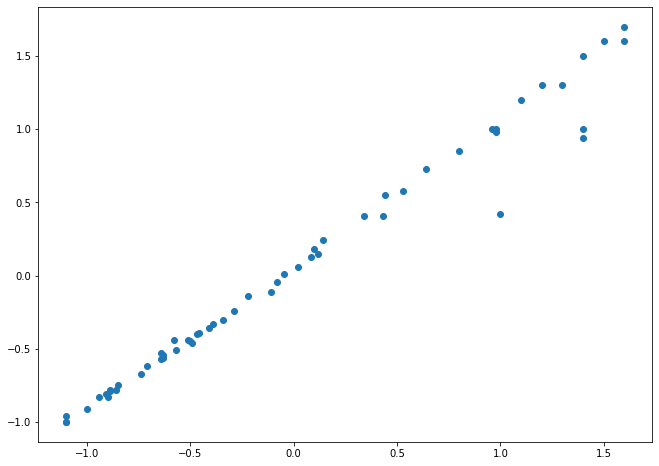

In [17]:
phi_mean_connected = connected_summary.iloc[phi_rows,0]
phi_mean_islands = islands_summary.iloc[phi_rows,0]
plt.scatter(phi_mean_connected, phi_mean_islands)

In [18]:
print('connected\n{}\n\nislands\n{}'.format(connected_summary.iloc[theta_rows,:][0:14], islands_summary.iloc[theta_rows,:][0:14]))

connected
            Mean   MCSE  StdDev   5%    50%  95%   N_Eff  N_Eff/s  R_hat
name                                                                    
theta[1]   0.310  0.013    0.99 -1.3  0.330  1.9  5544.0    497.0    1.0
theta[2]   0.170  0.013    0.97 -1.4  0.170  1.7  5185.0    465.0    1.0
theta[3]   0.140  0.011    0.98 -1.5  0.160  1.7  7954.0    714.0    1.0
theta[4]   0.240  0.013    1.00 -1.4  0.270  1.9  6125.0    550.0    1.0
theta[5]   0.170  0.012    0.98 -1.5  0.180  1.8  6833.0    613.0    1.0
theta[6]  -0.180  0.012    1.00 -1.8 -0.190  1.5  7146.0    641.0    1.0
theta[7]   0.270  0.013    0.96 -1.4  0.280  1.8  5408.0    485.0    1.0
theta[8]   0.056  0.013    1.00 -1.6  0.051  1.8  6780.0    608.0    1.0
theta[9]   0.220  0.011    0.97 -1.4  0.240  1.8  7373.0    662.0    1.0
theta[10]  0.110  0.012    0.94 -1.4  0.090  1.7  5758.0    517.0    1.0
theta[11]  0.090  0.012    0.95 -1.5  0.100  1.7  6330.0    568.0    1.0
theta[12] -0.100  0.010    0.97 -1.7 -0.1

We can also fit the connected graph as if it were a disconnected graph; the `BYM2_islands.stan` program allows graphs with a single component as input, all we need to do is supply the additional input data structures "K", "K_node_cts", etc.

In [19]:
with open('scotland_connected_as_Kgraph.data.json') as fd:
    s2_data = json.load(fd)
bym2_islands_model = CmdStanModel(stan_file='bym2_islands.stan')
bym2_s2_fit = bym2_islands_model.sample(data=s2_data, seed=12345)

s2_summary = bym2_s2_fit.summary()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/mitzi/github/stan-dev/example-models/knitr/car-iar-poisson/update_2021_02/bym2_islands
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


Both models returns the same estimates, although the islands model is slower, due to the overhead of the indexing operations.

In [20]:
print('connected, fit with bym2_model\n{}\n\nconnected, fit with bym2_islands model\n{}'.format(connected_summary.iloc[1:5,:], s2_summary.iloc[1:5,:]))

connected, fit with bym2_model
       Mean    MCSE  StdDev    5%   50%   95%   N_Eff  N_Eff/s  R_hat
name                                                                 
alpha -0.21  0.0027   0.120 -0.41 -0.21 -0.01  2100.0    190.0    1.0
beta   0.36  0.0029   0.130  0.15  0.36  0.57  2000.0    180.0    1.0
rho    0.88  0.0053   0.140  0.57  0.94  1.00   690.0     61.0    1.0
sigma  0.71  0.0019   0.059  0.62  0.71  0.81   930.0     83.0    1.0

connected, fit with bym2_islands model
       Mean    MCSE  StdDev    5%   50%   95%   N_Eff  N_Eff/s  R_hat
name                                                                 
alpha -0.21  0.0027   0.120 -0.41 -0.21 -0.01  2100.0    150.0    1.0
beta   0.36  0.0029   0.130  0.15  0.36  0.57  2000.0    140.0    1.0
rho    0.88  0.0053   0.140  0.57  0.94  1.00   690.0     48.0    1.0
sigma  0.71  0.0019   0.059  0.62  0.71  0.81   930.0     65.0    1.0


### Mainland plus 1 singleton, and combined Shetland + Orkney component

For the Scotland map with 3 components, in file `scotland_3_comps_nbs.data.R`, the islands of Shetland and Orkney have been combined.  This dataset exists to test additional possible kinds of maps, but provides no additional insights on the model or the domain data.

In [21]:
bym2_c3_fit = bym2_islands_model.sample(data='scotland_3_comp.data.json', seed=12345)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


In [22]:
c3_summary = bym2_c3_fit.summary()
c3_summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,750.00,0.3300,9.100,740.00,760.00,770.00,750.0,12.0,1.0
alpha,-0.32,0.0028,0.130,-0.54,-0.32,-0.11,2000.0,33.0,1.0
beta,0.47,0.0032,0.130,0.25,0.47,0.68,1700.0,27.0,1.0
rho,0.79,0.0082,0.190,0.43,0.84,1.00,520.0,8.4,1.0
sigma,0.71,0.0019,0.058,0.62,0.71,0.81,900.0,15.0,1.0
...,...,...,...,...,...,...,...,...,...
y_prime[53],2.30,0.0100,0.890,1.10,2.20,3.90,7276.0,118.0,1.0
y_prime[54],2.80,0.0140,0.970,1.50,2.70,4.60,4836.0,78.0,1.0
y_prime[55],3.70,0.0220,1.300,1.90,3.50,6.00,3422.0,55.0,1.0
